In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.transforms import Bbox
from picard import amari_distance
from tqdm import tqdm

from generate_data import generate_data
from multiviewica_dilations_shifts import mvica_ds
from plot_functions import plot_sources_2d, plot_sources_3d, scatter_plot_shifts_or_dilations, plot_amari_across_iters
from apply_dilations_shifts import apply_dilations_shifts_3d_no_argmin
from other_functions import find_order

from multiviewica_delay import multiviewica_delay

# parameters

In [3]:
m = 5
p = 3
n = 600
max_shift = 0.05
max_dilation = 1.15
noise_data = 0.01
noise_model = 1  # 1 by default
S1_S2_scale = 0.7  # 1 for first function, 0 for second function, 0.5 (for example) for a mixture of both
n_bins = 10  # should divide n
freq_level = 50
number_of_filters_squarenorm_f = 0
filter_length_squarenorm_f = 3
use_envelop_term = True
number_of_filters_envelop = 1
filter_length_envelop = 10
dilation_scale_per_source = True
W_scale = 15
random_state = 0
n_concat = 5  # should divide n
A_B_init_permica = True
penalization_scale = 1e1
verbose = True
return_all_iterations = True
nb_points_grid_init = 10

In [4]:
rng = np.random.RandomState(random_state)

# generate data

In [5]:
X_list, A_list, dilations, shifts, S_list, S = generate_data(
    m=m,
    p=p,
    n=n,
    max_shift=max_shift,
    max_dilation=max_dilation,
    noise_data=noise_data,
    n_bins=n_bins,
    freq_level=freq_level,
    S1_S2_scale=S1_S2_scale,
    rng=rng,
    n_concat=n_concat,
)

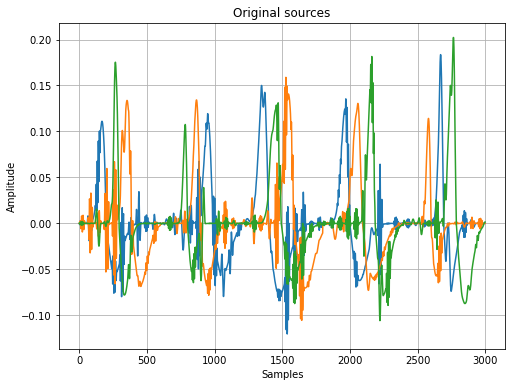

In [6]:
plot_sources_2d(S)

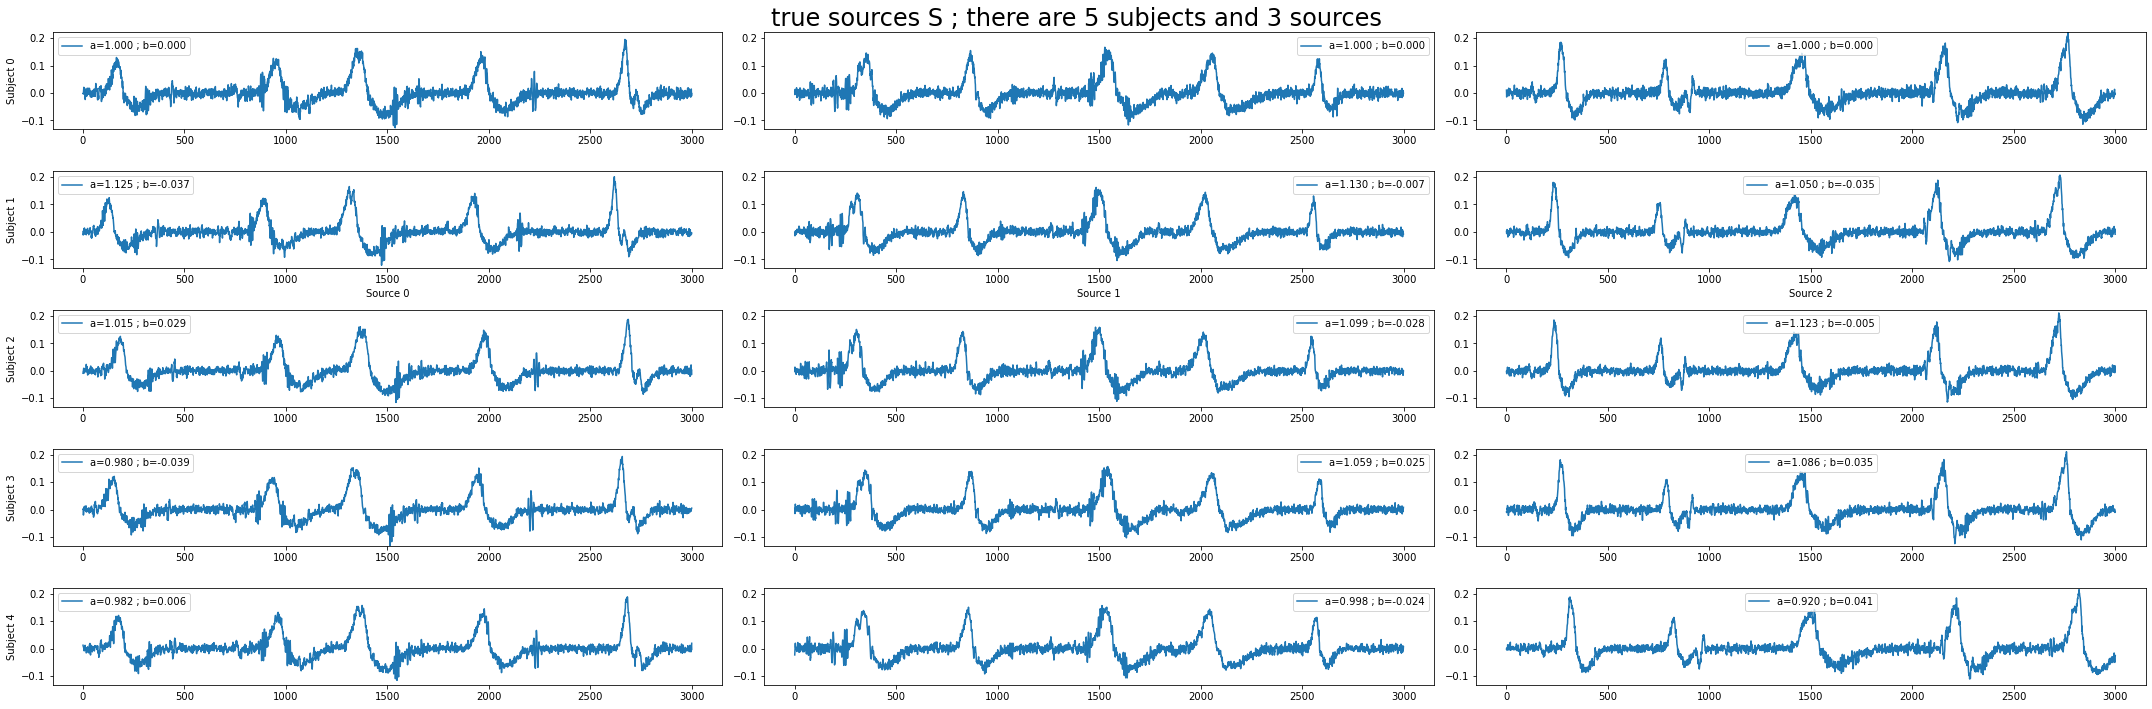

In [7]:
plot_sources_3d(S_list, dilations=dilations, shifts=shifts);

# L-BFGS

In [8]:
W_list_lbfgsb, dilations_lbfgsb, shifts_lbfgsb, Y_list_lbfgsb, callback, W_list_permica, dilations_permica, shifts_permica = mvica_ds(
    X_list,
    n_concat,
    max_dilation,
    max_shift,
    W_scale,
    dilation_scale_per_source,
    verbose,
    random_state,
    noise_model,
    number_of_filters_envelop,
    filter_length_envelop,
    number_of_filters_squarenorm_f,
    filter_length_squarenorm_f,
    use_envelop_term,
    penalization_scale,
    return_all_iterations,
    nb_points_grid_init,
)


Preprocess permica data...
Preprocessing done.
Jit...
Jit time : 2.8252501487731934
LBFGSB...
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           75     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.42736D+01    |proj g|=  4.90018D+00

At iterate    1    f=  5.39130D+00    |proj g|=  1.81098D+00

At iterate    2    f=  1.21386D+00    |proj g|=  1.25517D+00

At iterate    3    f= -5.44175D+00    |proj g|=  7.37131D-01

At iterate    4    f= -1.15550D+01    |proj g|=  4.55009D-01

At iterate    5    f= -1.83510D+01    |proj g|=  2.71686D-01

At iterate    6    f= -2.49511D+01    |proj g|=  1.63461D-01

At iterate    7    f= -3.11191D+01    |proj g|=  9.86843D-02

At iterate    8    f= -3.64670D+01    |proj g|=  5.36412D-02

At iterate    9    f= -3.98860D+01    |proj g|=  1.09082D-01

At iterate   10    f= -4.18593D+01    |proj g|=  1.21644D-01

At iterate   11    f= -4.31721D+01    |proj g|=  8.6327

# correct sources order and center time parameters

In [9]:
# correct order for permica
S_list_permica = np.array([np.dot(W, X) for W, X in zip(W_list_permica, X_list)])
Y_list_permica = apply_dilations_shifts_3d_no_argmin(
    S=S_list_permica, dilations=dilations_permica, shifts=shifts_permica, max_dilation=max_dilation,
    max_shift=max_shift, shift_before_dilation=False, n_concat=n_concat)
Y_avg_permica = np.mean(Y_list_permica, axis=0)
order_permica = find_order(S, Y_avg_permica)

dilations_permica_o = dilations_permica[:, order_permica]
shifts_permica_o = shifts_permica[:, order_permica]
S_list_permica_o = S_list_permica[:, order_permica]
Y_list_permica_o = Y_list_permica[:, order_permica]
W_list_permica_o = W_list_permica[:, order_permica]

# correct order for L-BFGS-B
S_list_lbfgsb = np.array([np.dot(W, X) for W, X in zip(W_list_lbfgsb, X_list)])
Y_list_lbfgsb = apply_dilations_shifts_3d_no_argmin(
    S=S_list_lbfgsb, dilations=dilations_lbfgsb, shifts=shifts_lbfgsb, max_dilation=max_dilation,
    max_shift=max_shift, shift_before_dilation=False, n_concat=n_concat)
Y_avg_lbfgsb = np.mean(Y_list_lbfgsb, axis=0)
order_lbfgsb = find_order(S, Y_avg_lbfgsb)

dilations_lbfgsb_o = dilations_lbfgsb[:, order_lbfgsb]
shifts_lbfgsb_o = shifts_lbfgsb[:, order_lbfgsb]
S_list_lbfgsb_o = S_list_lbfgsb[:, order_lbfgsb]
Y_list_lbfgsb_o = Y_list_lbfgsb[:, order_lbfgsb]
W_list_lbfgsb_o = W_list_lbfgsb[:, order_lbfgsb]

In [10]:
# center time parameters
dilations_c = dilations - np.mean(dilations, axis=0) + 1
shifts_c = shifts - np.mean(shifts, axis=0)
dilations_permica_c = dilations_permica_o - np.mean(dilations_permica_o, axis=0) + 1
shifts_permica_c = shifts_permica_o - np.mean(shifts_permica_o, axis=0)
dilations_lbfgsb_c = dilations_lbfgsb_o - np.mean(dilations_lbfgsb_o, axis=0) + 1
shifts_lbfgsb_c = shifts_lbfgsb_o - np.mean(shifts_lbfgsb_o, axis=0)

# errors
error_dilations_permica = np.mean((dilations_c - dilations_permica_c) ** 2)
error_shifts_permica = np.mean((shifts_c - shifts_permica_c) ** 2)
error_dilations_lbfgsb = np.mean((dilations_c - dilations_lbfgsb_c) ** 2)
error_shifts_lbfgsb = np.mean((shifts_c - shifts_lbfgsb_c) ** 2)

# evaluate init

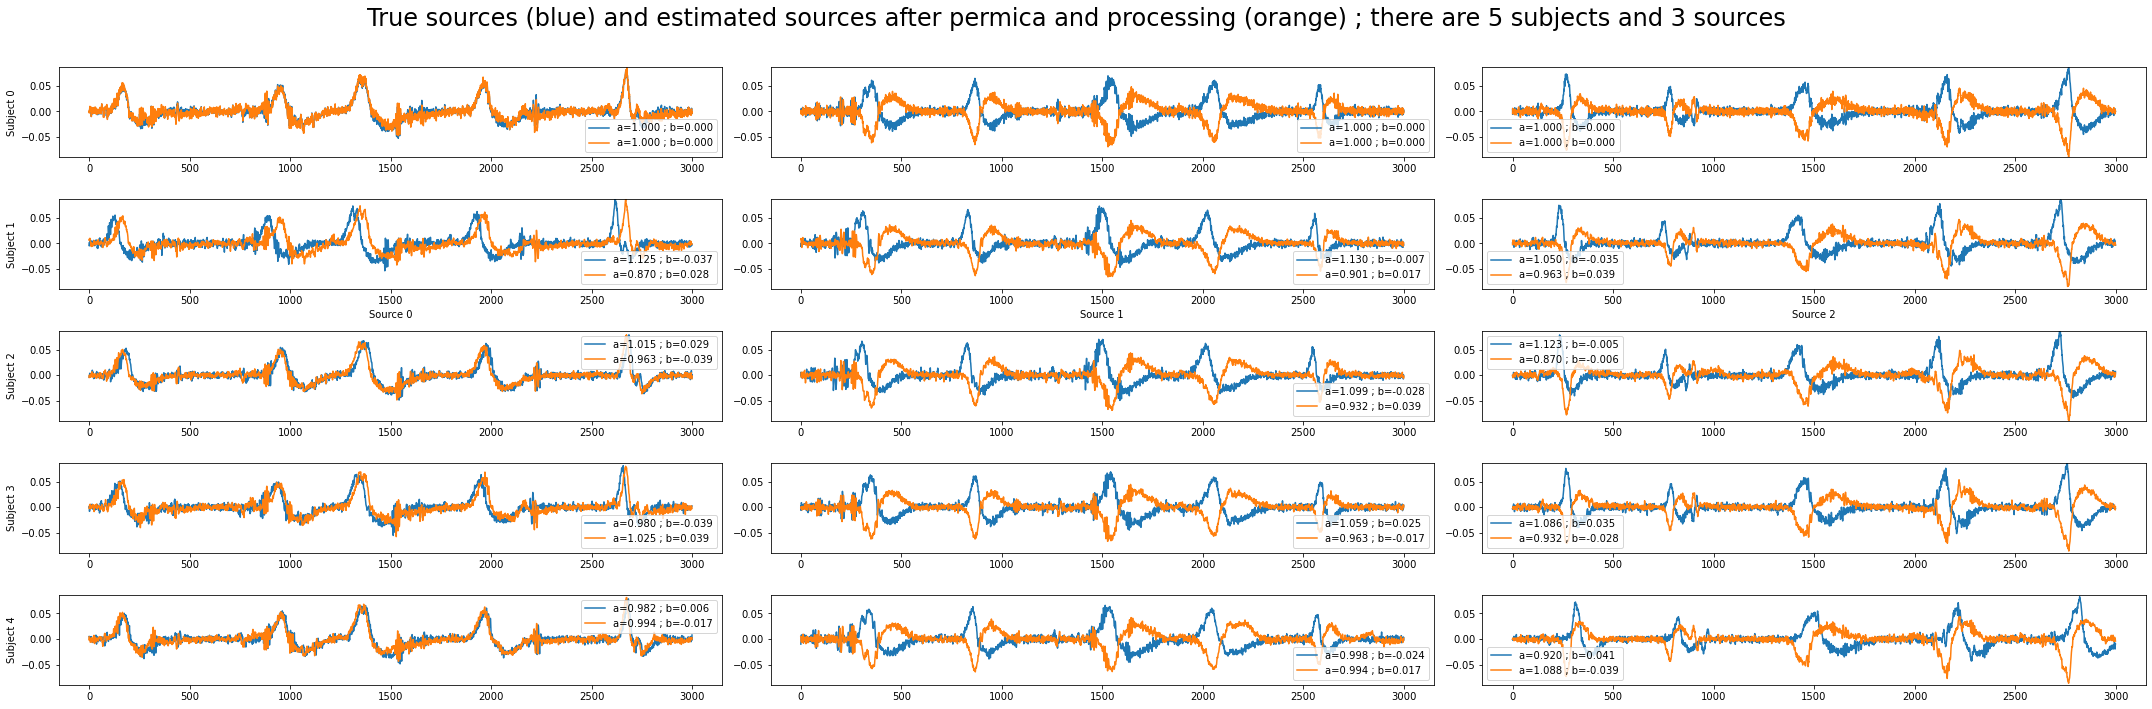

In [11]:
axes = plot_sources_3d(
    S_list / np.linalg.norm(S_list, axis=-1, keepdims=True), dilations=dilations, shifts=shifts, show=False)
plot_sources_3d(
    Y_list_permica_o / np.linalg.norm(Y_list_permica_o, axis=-1, keepdims=True), dilations=dilations_permica_o, shifts=shifts_permica_o,
    axes=axes, title="True sources (blue) and estimated sources after permica and processing (orange)");

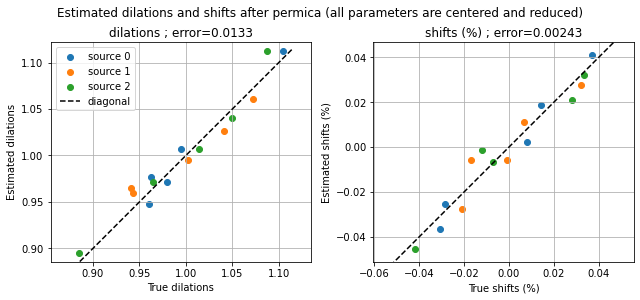

In [12]:
# scatter plots of estimated shifts and dilations
fig, axes = plt.subplots(1, 2, figsize=(9, 4))

[ax.axis("equal") for ax in axes]
[ax.grid(True) for ax in axes]

scatter_plot_shifts_or_dilations(
    dilations_c,
    1/dilations_permica_c,
    error_dilations_permica,
    dilations_not_shifts=True,
    legend=True,
    ax=axes[0],
)
scatter_plot_shifts_or_dilations(
    shifts_c,
    -shifts_permica_c,
    error_shifts_permica,
    dilations_not_shifts=False,
    legend=False,
    ax=axes[1],
)
fig.suptitle(
    f"Estimated dilations and shifts after permica (all parameters are centered and reduced)",
    y=1.03,
)
# plt.savefig("scatter_plot.pdf", bbox_inches=Bbox([[0, 0], [9, 4.25]]))
plt.show()

# evaluate L-BFGS-B

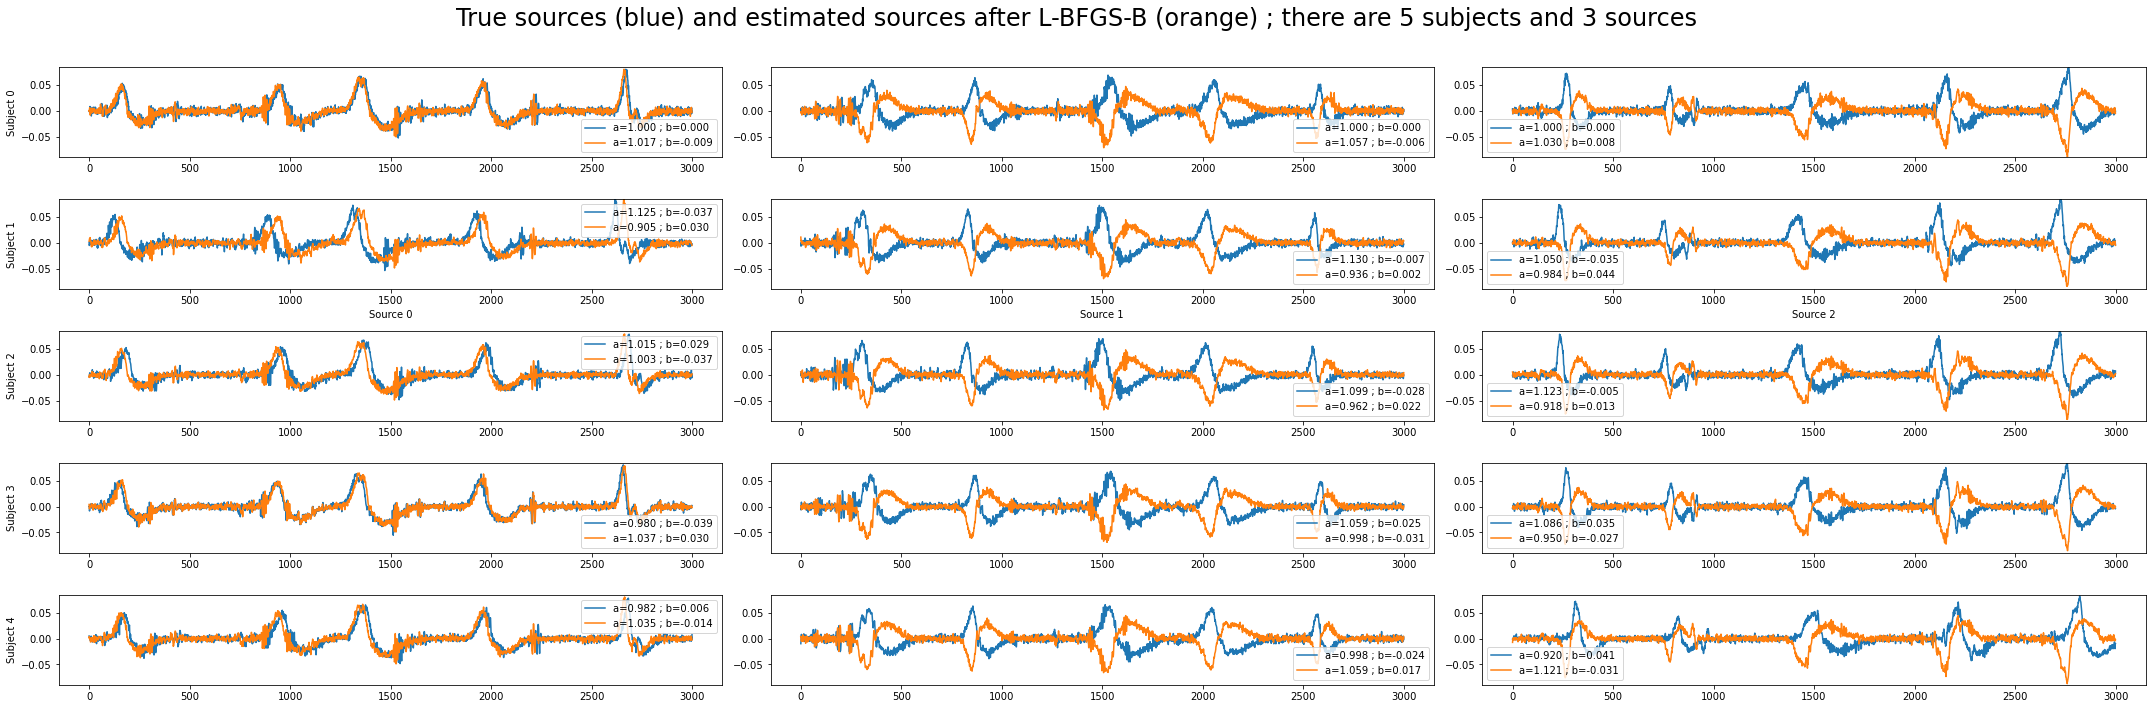

In [13]:
axes = plot_sources_3d(
    S_list / np.linalg.norm(S_list, axis=-1, keepdims=True), dilations=dilations, shifts=shifts, show=False)
plot_sources_3d(
    Y_list_lbfgsb_o / np.linalg.norm(Y_list_lbfgsb_o, axis=-1, keepdims=True), dilations=dilations_lbfgsb_o, shifts=shifts_lbfgsb_o,
    axes=axes, title="True sources (blue) and estimated sources after L-BFGS-B (orange)");

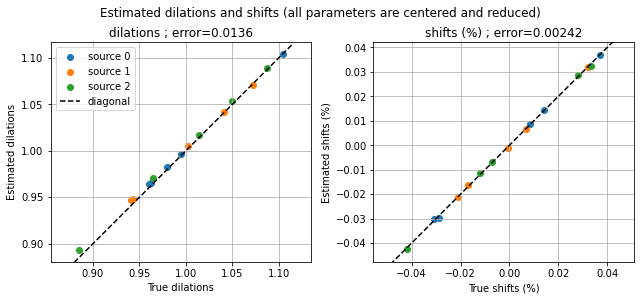

In [14]:
# scatter plots of estimated shifts and dilations
fig, axes = plt.subplots(1, 2, figsize=(9, 4))

[ax.axis("equal") for ax in axes]
[ax.grid(True) for ax in axes]

scatter_plot_shifts_or_dilations(
    dilations_c,
    1/dilations_lbfgsb_c,
    error_dilations_lbfgsb,
    dilations_not_shifts=True,
    legend=True,
    ax=axes[0],
)
scatter_plot_shifts_or_dilations(
    shifts_c,
    -shifts_lbfgsb_c,
    error_shifts_lbfgsb,
    dilations_not_shifts=False,
    legend=False,
    ax=axes[1],
)
fig.suptitle(
    f"Estimated dilations and shifts (all parameters are centered and reduced)",
    y=1.03,
)
# plt.savefig("scatter_plot.pdf", bbox_inches=Bbox([[0, 0], [9, 4.25]]))
plt.show()

# MVICAD

In [15]:
# MVICAD max_delay=max_shift
_, W_mvicad, S_mvicad, _, shifts_mvicad, _ = multiviewica_delay(
    X_list,
    init=W_list_permica,
    shared_delays=False,
    max_delay=int(max_shift*n),
    random_state=random_state,
    continuous_delays=False,
)

# MVICAD max_delay=max_delay
max_delay = (1 + max_shift) * max_dilation - 1
max_delay_samples = np.ceil(max_delay * n).astype("int")

_, W_mvicad_2, S_mvicad_2, _, shifts_mvicad_2, _ = multiviewica_delay(
    X_list,
    init=W_list_permica,
    shared_delays=False,
    max_delay=max_delay_samples,
    random_state=random_state,
    continuous_delays=False,
)

# compute Amari distance
amari_mvicad = np.mean([amari_distance(W, A) for W, A in zip(W_mvicad, A_list)])
amari_mvicad_2 = np.mean([amari_distance(W, A) for W, A in zip(W_mvicad_2, A_list)])

# plot Amari distance

In [16]:
amari_init = np.mean([amari_distance(W, A) for W, A in zip(W_list_permica, A_list)])
amari_lbfgsb = [amari_init]
for W_list in tqdm(callback.memory_W):
    amari_lbfgsb.append(np.mean([amari_distance(W, A) for W, A in zip(W_list, A_list)]))

100%|██████████| 3000/3000 [00:00<00:00, 3222.25it/s]


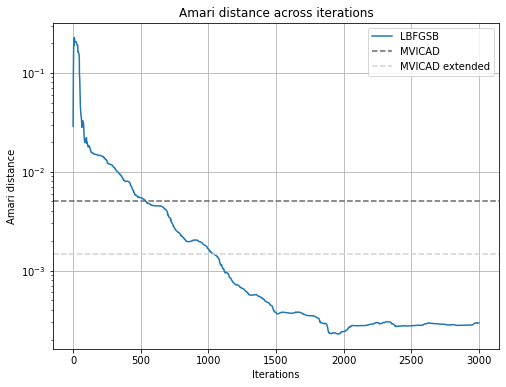

In [17]:
plot_amari_across_iters(amari_lbfgsb, amari_mvicad=amari_mvicad, amari_mvicad_ext=amari_mvicad_2)